# Toward Unifying the Non-Uniform Fast Fourier Transform (NUFFT) and Neuromorphic Sampling

MATH7001: Advanced Mathematical Investigations

Kyra Lee

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq, ifft
from scipy.interpolate import interp1d
import finufft

## Why Explore the NUFFT?
- Neuromorphic sensors sample asynchronously — they spike in response to meaningful changes

- This event-driven sampling breaks assumptions behind standard tools like the FFT  

- But, frequency analysis and reconstruction are still essential 

- The NUFFT can be a tool that bridges this gap, enabling fast, accurate spectral analysis from spike-based data

![](Table.png)

## Literature Review Takeaways
- FFT has been widely used in neuromorphic engineering, but may blur temporal precision or introduce artifacts

- Recent research focuses on improving the NUFFT algorithm, but rarely applies it to event-based signals

- To date, no known studies have applied the NUFFT to neuromorphic data directly

- Rather than being contradictory to existing techniques, the NUFFT can be seen as a complementary approach that enhances their capabilities

## NUFFT Overview  (NU to U)
1. NUFFT takes data at unevenly spaced points.

2. It uses a special "kernel function" to "spread" each data point onto a regular, evenly spaced grid.

3. Then it applies a regular FFT to this grid.

4. Finally, it does some correction (scaling/deconvolution) to get the final result.


![](chart.png)

# Discrete Fourier Transform (DFT)
Given $N$ uniformly spaced time samples $f_j$ at positions $x_j = \frac{2\pi j}{N}$:
$$
\hat{f}_k = \sum_{j=0}^{N-1} f_j \, e^{-i k x_j}, \quad k = 0, 1, \dots, N-1
$$
 
How do we generalize this to handle cases where the samples are not on a uniform grid?

# Non-Uniform DFT
Given $N$ arbitrary time samples $f_j$ at locations $x_j \in [-\pi, \pi]$
$$
\hat{f}_k = \sum_{j=0}^{M-1} f_j \, e^{-i k x_j}, \quad k = -K, \dots, K
$$

The NUDFT is exact but computationally expensive: $ \mathcal{O}(MN)$


# Non-Uniform Fast Fourier Transform (NUFFT)

Type 1 NUFFT: Compute a set of uniform frequency coefficients $\hat{f}_k$ given $M$ data points $f_j$ sampled at non-uniform locations $x_j \in  [-\pi, \pi]$. 

$$
\hat{f}_k = \sum_{j=0}^{M-1} f_j \, e^{-i k x_j}, \quad k = -K, \dots, K
$$

Mathematically identical to the NUDFT but uses approximation strategies to bring the complexity down to roughly $ \mathcal{O}(N \log N + M) $

# When Not To Use the NUFFT for Neuromorphic Data

1. N, M need to be large enough

2. If spike events are too sparse or unevenly clustered, large gaps in time leave parts of the signal undersampled or completely unrepresented

# FINUFFT 

Library for computing nonuniform fast Fourier transforms (NUFFTs), written in C++ with interfaces for Python, MATLAB, and Fortran 

Why FINUFFT? High speed, less RAM, automated kernel parameters

## Assumptions and Conditions

## 1. Default kernel: "exponential of semi-circle"
 $$\phi(z) = e^{\beta \sqrt{1 - z^2}} \mathrm{\,for\,} z \in [-1,1],  0 \mathrm{\, otherwise} $$
because this kernel has been proven to result in an error that decreases exponentially. 

## 2. Deconvolution: diagonal scaling in frequency space
Each nonuniform point is spread to a nearby set of uniform grid points using the kernel. 

This spreading is equivalent to a convolution of the original signal: 

$$ f_{\text{grid}}(x) = (f * \phi)(x) $$

When we apply the FFT to this convolved signal, we are computing the Fourier transform of the blurred data. 

By the Convolution Theorem, convolution in time corresponds to multiplication in frequency so:
 $$ \widehat{f_{\text{grid}}}(k) = \hat{f}_k \cdot \hat{\phi}_k $$


To recover the original frequency coefficients, we must undo the convolution by dividing by the Fourier transform of the kernel: 
$$ \hat{f}_k = \frac{\widehat{f_{\text{grid}}}(k)}{\hat{\phi}_k} $$

In practice, this deconvolution is implemented as a diagonal scaling in the frequency domain. Let $\mathbf{\hat{f}}$ be the vector of Fourier coefficients and let $\mathbf{D}$ be a diagonal matrix where:$$ D_{kk} = \hat{\phi}_k $$

Then, $$ \mathbf{\hat{f}} = \mathbf{D}^{-1} \cdot \widehat{f_{\text{grid}}} $$

This is diagonal scaling because we are multiplying the vector by a diagonal matrix (or equivalently, dividing each component by $\hat{\phi}_k$).

# NUFFT vs FFT Reconstruction of Simple Sine Wave

- Standard FFT assumes uniform sampling — applying it to nonuniform data distorts both the spectrum and the reconstructed signal

- NUFFT respects nonuniform sample locations, enabling accurate spectral and time-domain reconstruction when sampling is reasonable

- But nonuniform sampling itself can still cause issues especially when samples are clustered or poorly distributed

- More samples help, but only if they adequately cover the signal domain and avoid long gaps or heavy clustering


c:\Users\kyral\.vscode\NUFFT Work\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\kyral\.vscode\NUFFT Work\.venv\Lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


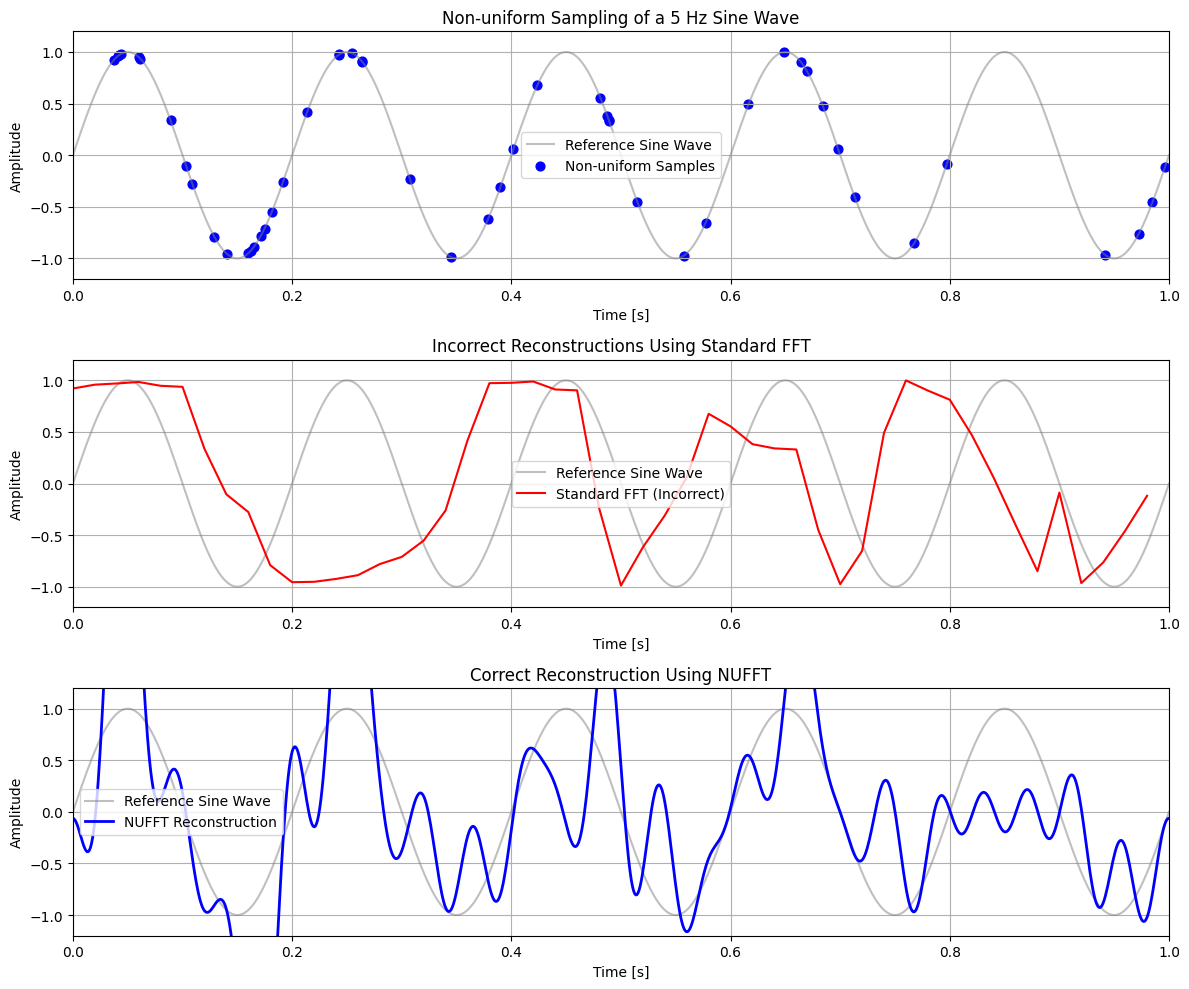

In [15]:
# Parameters
frequency = 5  # Hz (signal frequency)
duration = 1  # second (signal duration)
N = 1000       # Number of samples

# Uniform sine wave generator
def uniform_sine_wave(frequency, duration, N):
    t = np.linspace(0, duration, N, endpoint=False)
    y = np.sin(2 * np.pi * frequency * t)
    return t, y.astype(np.complex128)

# Non-uniform sine wave generator
def NU_sine_wave(frequency, duration, N):
    t = np.sort(np.random.uniform(0, duration, N))
    y = np.sin(2 * np.pi * frequency * t)
    return t, y.astype(np.complex128)

# Generate both types of signals
t_uniform, y_uniform = uniform_sine_wave(frequency, duration, N)
t_nu, y_nu = NU_sine_wave(frequency, duration, N)



def compare_reconstruction_methods():
    # Parameters
    frequency = 5  # Hz (signal frequency)
    duration = 1.0  # second (signal duration)
    N = 50  # Number of samples
    
    # Generate reference high-resolution sine wave
    t_ref = np.linspace(0, duration, 1000)
    y_ref = np.sin(2 * np.pi * frequency * t_ref)
    
    # Generate non-uniform samples
    t_nu, y_nu = NU_sine_wave(frequency, duration, N)
    
    # Create uniform time grid for interpolation comparison
    t_uniform = np.linspace(0, duration, N, endpoint=False)
    
    # Standard FFT approach (incorrect for non-uniform data)
    fft_result = np.fft.fft(y_nu)
    ifft_result = np.fft.ifft(fft_result)
    
    # Interpolation approach (linear interpolation onto uniform grid)
    interp_func = interp1d(t_nu, y_nu, kind='linear', bounds_error=False, fill_value=0)
    y_interp = interp_func(t_uniform)
    fft_interp = np.fft.fft(y_interp)
    ifft_interp = np.fft.ifft(fft_interp)
    
    # NUFFT
    
    # Step 1: Normalize time points to [-π, π] (FINUFFT expects points in [-π, π] range)
    t_nu_scaled = (t_nu / duration) * 2 * np.pi - np.pi
    t_recon = np.linspace(0, duration, 1000)
    t_recon_scaled = (t_recon / duration) * 2 * np.pi - np.pi

    # Step 2: Forward NUFFT (non-uniform time -> uniform frequency)
    fhat = finufft.nufft1d1(t_nu_scaled, y_nu.astype(np.complex128), N, eps=1e-12)

    # Step 3: Inverse NUFFT (uniform frequency -> fine non-uniform time points)
    y_recon = finufft.nufft1d2(t_recon_scaled, fhat, eps=1e-12) / N  # Don't forget scaling by N!

    
    # Plotting
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Non-uniform sampling
    plt.subplot(3, 1, 1)
    plt.plot(t_ref, y_ref, 'gray', label='Reference Sine Wave', alpha=0.5)
    plt.scatter(t_nu, y_nu, color='blue', s=40, label='Non-uniform Samples')
    plt.title("Non-uniform Sampling of a 5 Hz Sine Wave")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, duration)
    plt.ylim(-1.2, 1.2)
    
    # Plot 2: Incorrect reconstructions (standard FFT and interpolation)
    plt.subplot(3, 1, 2)
    plt.plot(t_ref, y_ref, 'gray', label='Reference Sine Wave', alpha=0.5)
    plt.plot(t_uniform, ifft_result.real, 'r-', label='Standard FFT (Incorrect)')
    plt.title("Incorrect Reconstructions Using Standard FFT")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, duration)
    plt.ylim(-1.2, 1.2)
    
    # Plot 3: NUFFT reconstruction
    plt.subplot(3, 1, 3)
    plt.plot(t_ref, y_ref, 'gray', label='Reference Sine Wave', alpha=0.5)
    plt.plot(t_recon, y_recon.real, 'b-', label='NUFFT Reconstruction', linewidth=2)
    plt.title("Correct Reconstruction Using NUFFT")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, duration)
    plt.ylim(-1.2, 1.2)
    
    plt.tight_layout()
    plt.show()


compare_reconstruction_methods()


NUFFT gives us the right lens — but what we see still depends on the quality of the data we're looking at

## NUFFT for Neuromorphic Spikes
Let's generate a synthetic spike train and analyze how the NUFFT handles such data.

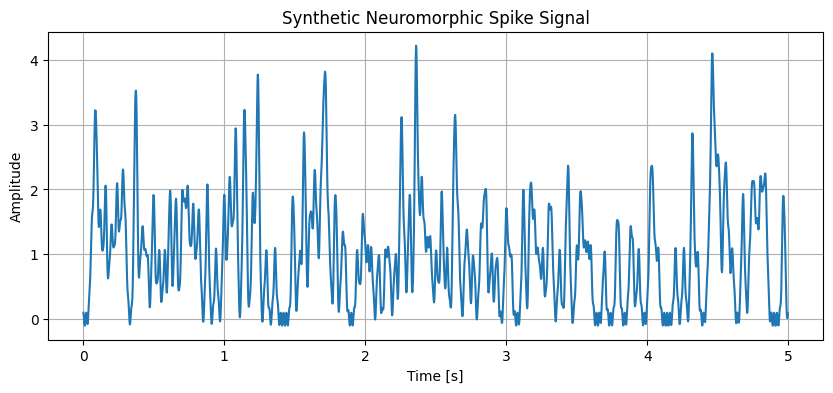

In [82]:
def generate_spike_train(duration=5.0, N=1000, spike_count=500, decay=0.01, high_freq=True):
    # Non-uniform spike times (random placement)
    times = np.sort(np.random.uniform(0, duration, spike_count))
    
    # Signal time grid
    signal_time = np.linspace(0, duration, N, endpoint=False)
    signal = np.zeros_like(signal_time)
    
    # Adding spikes to the signal with a Gaussian decay
    for spike_time in times:
        spike = np.exp(-(signal_time - spike_time)**2 / (2 * decay**2))
        signal += spike
    
    # Add high-frequency oscillations to the signal
    if high_freq:
        # Adding a high-frequency component (e.g., 50 Hz)
        freq = 50  # High frequency component to make signal more complex
        signal += 0.1 * np.cos(2 * np.pi * freq * signal_time)
    
    return signal_time, signal.astype(np.complex128), times

# Generate a high-resolution reference signal once
duration = 5.0
N_ref = 2000  # High resolution reference
spike_count = 200
t_ref, y_ref, spike_times = generate_spike_train(duration, N_ref, spike_count)

# Plot the original signal with sparse spikes and high-frequency component
plt.figure(figsize=(10, 4))
plt.plot(t_ref, y_ref.real)
plt.title("Synthetic Neuromorphic Spike Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

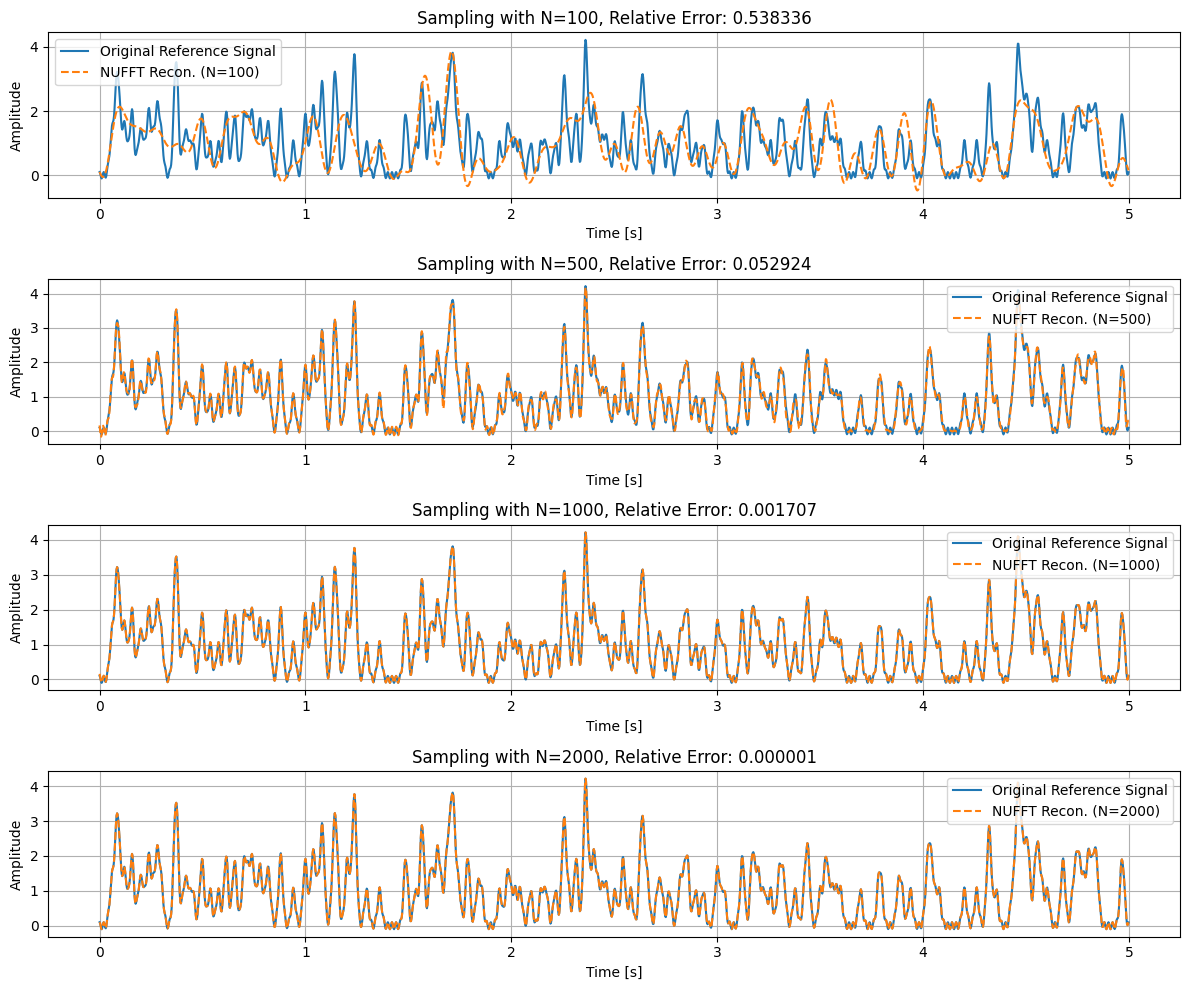

In [83]:
# Create a figure with subplots for different sample counts
N_list = [100, 500, 1000, 2000]
fig, axes = plt.subplots(len(N_list), 1, figsize=(12, 10))

# Plot the original reference signal on all subplots for comparison
for idx, N in enumerate(N_list):
    # Sample the reference signal at N points (simulating different sampling rates)
    sample_indices = np.linspace(0, len(t_ref)-1, N, dtype=int)
    t_sample = t_ref[sample_indices]
    y_sample = y_ref[sample_indices]
    
    # Normalize times to [-π, π] for NUFFT
    omega_sample = 2 * np.pi * (t_sample / duration - 0.5)
    
    # Forward NUFFT: nonuniform time → uniform frequency
    nufft_vals = finufft.nufft1d1(omega_sample, y_sample, N, isign=-1)
    
    # Compute inverse NUFFT back to the original reference time points
    omega_ref = 2 * np.pi * (t_ref / duration - 0.5)
    nufft_reconstructed = finufft.nufft1d2(omega_ref, nufft_vals, isign=1) / N
    
    # Calculate reconstruction error
    error = np.linalg.norm(y_ref.real - nufft_reconstructed.real) / np.linalg.norm(y_ref.real)
    
    # Plot both signals
    axes[idx].plot(t_ref, y_ref.real, '-', label="Original Reference Signal")
    axes[idx].plot(t_ref, nufft_reconstructed.real, '--', label=f"NUFFT Recon. (N={N})")
    axes[idx].set_title(f"Sampling with N={N}, Relative Error: {error:.6f}")
    axes[idx].set_xlabel("Time [s]")
    axes[idx].set_ylabel("Amplitude")
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

Completed N=50, MSE=0.837247
Completed N=75, MSE=0.663783
Completed N=100, MSE=0.522765
Completed N=150, MSE=0.249074
Completed N=200, MSE=0.109242
Completed N=500, MSE=0.005131
Completed N=1000, MSE=0.000194
Completed N=2000, MSE=0.000000


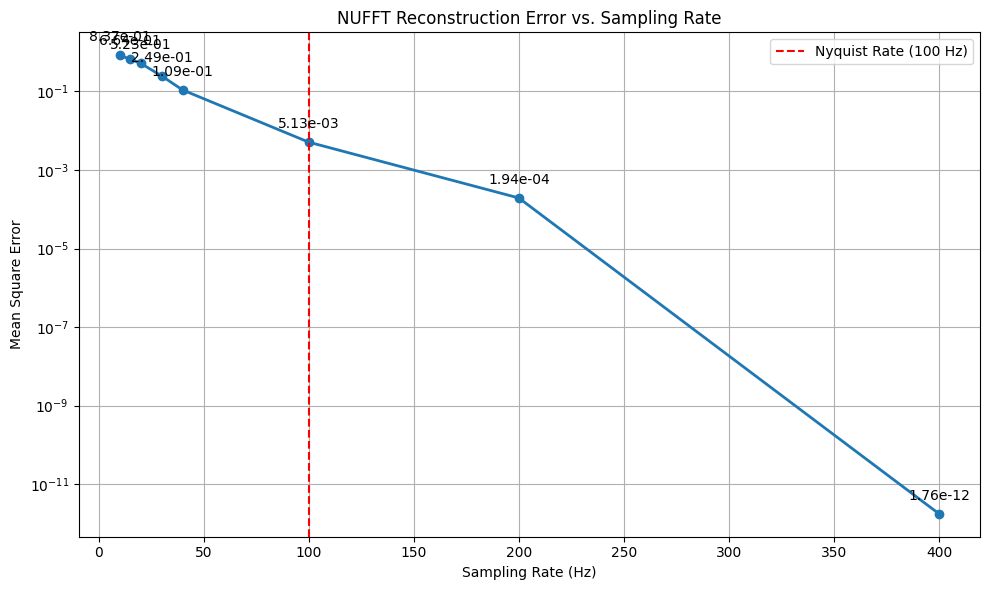


Summary of MSE Results:
-----------------------
N	Sampling Rate (Hz)	MSE
50	10.0		8.372472e-01
75	15.0		6.637832e-01
100	20.0		5.227650e-01
150	30.0		2.490738e-01
200	40.0		1.092418e-01
500	100.0		5.130862e-03
1000	200.0		1.943056e-04
2000	400.0		1.760849e-12


In [84]:
# Separate function to calculate MSE for different sampling rates
def calculate_nufft_mse(t_ref, y_ref, duration, N_list):
    mse_values = []
    
    for N in N_list:
        # Sample the reference signal at N points
        sample_indices = np.linspace(0, len(t_ref)-1, N, dtype=int)
        t_sample = t_ref[sample_indices]
        y_sample = y_ref[sample_indices]
        
        # Normalize times to [-π, π] for NUFFT
        omega_sample = 2 * np.pi * (t_sample / duration - 0.5)
        
        # Forward NUFFT: nonuniform time → uniform frequency
        nufft_vals = finufft.nufft1d1(omega_sample, y_sample, N, isign=-1)
        
        # Compute inverse NUFFT back to the original reference time points
        omega_ref = 2 * np.pi * (t_ref / duration - 0.5)
        nufft_reconstructed = finufft.nufft1d2(omega_ref, nufft_vals, isign=1) / N
        
        # Calculate reconstruction errors
        mse = np.mean(np.abs(y_ref.real - nufft_reconstructed.real)**2)
        
        # Store MSE for later plotting
        mse_values.append((N, mse))
        
        # Print progress
        print(f"Completed N={N}, MSE={mse:.6f}")
    
    return mse_values

# Function to plot MSE vs sampling rate
def plot_mse_results(mse_values, duration, nyquist_rate=100):
    plt.figure(figsize=(10, 6))
    sample_rates = [N/duration for N, _ in mse_values]  # Convert N to Hz
    mse_list = [mse for _, mse in mse_values]
    
    plt.plot(sample_rates, mse_list, 'o-', linewidth=2)
    plt.axvline(x=nyquist_rate, color='r', linestyle='--', label=f'Nyquist Rate ({nyquist_rate} Hz)')
    plt.title('NUFFT Reconstruction Error vs. Sampling Rate')
    plt.xlabel('Sampling Rate (Hz)')
    plt.ylabel('Mean Square Error')
    plt.grid(True)
    plt.legend()
    plt.yscale('log')  # Log scale to better visualize error reduction
    
    # Add annotations with exact MSE values
    for i, (N, mse) in enumerate(mse_values):
        plt.annotate(f"{mse:.2e}", 
                     (sample_rates[i], mse_list[i]),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\nSummary of MSE Results:")
    print("-----------------------")
    print("N\tSampling Rate (Hz)\tMSE")
    for N, mse in mse_values:
        print(f"{N}\t{N/duration:.1f}\t\t{mse:.6e}")


# Generate a high-resolution reference signal
duration = 5.0
N_ref = 2000  # High resolution reference
spike_count = 200
t_ref, y_ref, spike_times = generate_spike_train(duration, N_ref, spike_count)
    
# Sample counts to test (including more points around Nyquist rate)
N_list = [50, 75, 100, 150, 200, 500, 1000, 2000]
    
# Calculate MSE
mse_results = calculate_nufft_mse(t_ref, y_ref, duration, N_list)
    
# Plot results
plot_mse_results(mse_results, duration, nyquist_rate=100)

## NUFFT for Real Neuromorphic Olfaction Signals

- Effectively 1D
    - Though olfaction is spatiotemporal, many neuromorphic setups record odor concentration over time at fixed points, making the signal effectively 1D.

- Sparse and Irregular Sampling
    - Neuromorphic olfaction sensors emit spikes based on signal changes, producing nonuniform, event-driven data — well-suited to NUFFT.

- Spectral Content
    - Features such as dominant frequencies, decay rates, or harmonic structure can aid in characterization, comparison, or signal reconstruction.

![](animation.gif)

From Nik Dennler @ ETHZ:
 - the graphic above 
 
 - 3 csv files of electronic nose data (3 different wind speeds)

 - 2 sensors without saturation + time data = 3 columns x 274,966 rows

In [85]:
ENOSE1 = 'enose_r56.csv'
ENOSE2 = 'enose_r57.csv'
ENOSE3 = 'enose_r58.csv'

# Read the specific columns from each file
def read_enose_data(filename):
    try:
        # Read only columns 2 (time), 6 (sensor 4), and 10 (sensor 8)
        df = pd.read_csv(filename, usecols=[1, 5, 9])  # 0-indexed, so columns 1, 5, 9
        
        # Rename columns for clarity
        df.columns = ['Time (sec)', 'Sensor 4', 'Sensor 8']
        
        print(f"Successfully loaded {filename}")
        print(f"Data shape: {df.shape}")
        print(f"First few rows:\n{df.head()}")
        return df
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

# Read data from all three files
enose1_data = read_enose_data(ENOSE1)
enose2_data = read_enose_data(ENOSE2)
enose3_data = read_enose_data(ENOSE3)


Successfully loaded enose_r56.csv
Data shape: (274965, 3)
First few rows:
   Time (sec)   Sensor 4   Sensor 8
0    0.000000  217657.86  199978.92
1    0.001001  217674.03  199990.36
2    0.001999  217729.31  200016.20
3    0.002999  217760.22  200001.64
4    0.004001  217772.16  199992.20
Successfully loaded enose_r57.csv
Data shape: (274966, 3)
First few rows:
   Time (sec)   Sensor 4   Sensor 8
0    0.000000  183797.14  173726.14
1    0.001000  183797.83  173706.60
2    0.002002  183777.55  173682.88
3    0.003000  183786.06  173676.70
4    0.004001  183804.70  173689.67
Successfully loaded enose_r58.csv
Data shape: (274965, 3)
First few rows:
   Time (sec)   Sensor 4   Sensor 8
0    0.000000  186874.55  171812.30
1    0.001005  186858.58  171796.88
2    0.002004  186797.56  171776.36
3    0.003006  186730.22  171727.81
4    0.004000  186711.23  171692.14


## ENOSE 1 

- Although not truly neuromorphic, we can simulate spikes by detecting sharp changes in sensor data

- Compute the rate of change across sensor values to identify significant events

- Use a statistical threshold:

    - Threshold = mean + 2.0 × standard deviation

    - Captures roughly the top 2.5% of changes (assuming a normal distribution)

- This approach is data-adaptive — tailored to each dataset’s variability

- The factor 2.0 keeps the method interpretable and loosely aligned with the conventional p<0.05 significance threshold

- Plot raw signal with events overlaid to visualize where meaningful activity occurs



Percentage of events to signal: 4.48%
Percentage of events to signal: 4.52%


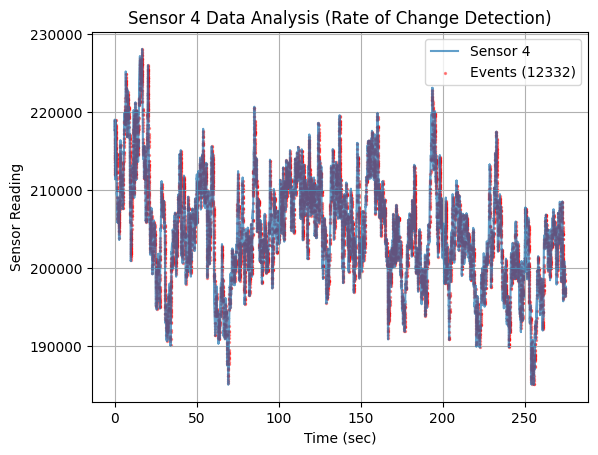

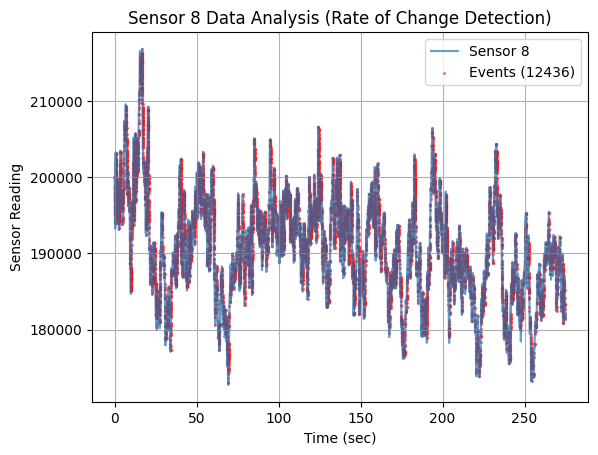

In [86]:
# Function to plot sensor data and detect events based on rate of change
def analyze_sensor_data(data, sensor_name, threshold_factor=2.0):
    
    # Calculate rate of change (derivative)
    sensor_values = data[sensor_name].values
    time_values = data['Time (sec)'].values
    
    rate_of_change = np.abs(np.diff(sensor_values) / np.diff(time_values))
    
    # Calculate threshold based on rate of change statistics
    # Flag an event any point where the rate of change is more than 2 standard deviations above the average rate of change
    roc_mean = np.mean(rate_of_change)
    roc_std = np.std(rate_of_change)
    roc_threshold = roc_mean + threshold_factor * roc_std
    
    # Find events where rate of change exceeds threshold
    event_indices = np.where(rate_of_change > roc_threshold)[0]
    # Add 1 to indices since we're looking at the point after the change
    event_indices = event_indices + 1
    
    # Plot the sensor data
    plt.plot(time_values, sensor_values, label=sensor_name, alpha=0.7)
    
    # Plot events 
    if len(event_indices) > 0:
        plt.scatter(time_values[event_indices], sensor_values[event_indices],
            color='red', alpha=0.4, s=2, label=f'Events ({len(event_indices)})')
    
    plt.title(f'{sensor_name} Data Analysis (Rate of Change Detection)')
    plt.xlabel('Time (sec)')
    plt.ylabel('Sensor Reading')
    plt.legend()
    plt.grid(True)

    percentage_events = (len(event_indices) / (len(sensor_values) - 1)) * 100
    print(f'Percentage of events to signal: {percentage_events:.2f}%')

plt.figure()
analyze_sensor_data(enose1_data, 'Sensor 4', 2.0)

plt.figure()
analyze_sensor_data(enose1_data, 'Sensor 8', 2.0)

## Toward Reconstruction via NUFFT

Before reconstructing, we first want a rough estimate of the signal’s frequency content

This helps assess whether reconstruction is feasible from the detected events

Only about 4% of the original samples are retained as events after thresholding

If the signal is sparse or compressible, then this small subset may still suffice

<Figure size 640x480 with 0 Axes>

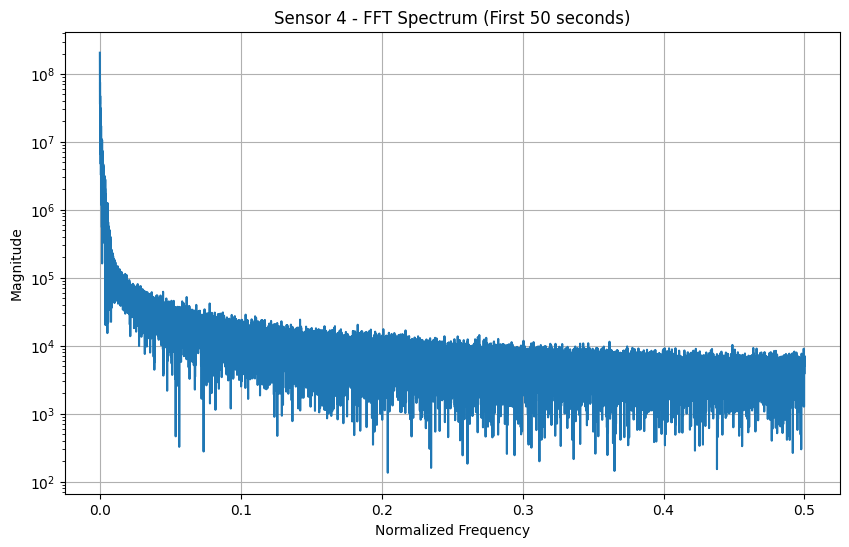

<Figure size 640x480 with 0 Axes>

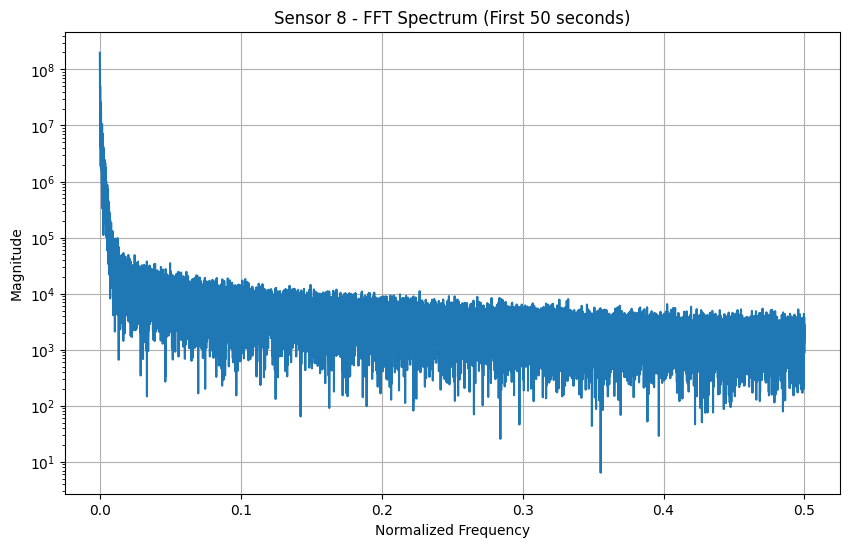

In [91]:
def plot_fft_spectrum(data, sensor_name, time_limit=50):
    
    # Filter data to first time_limit seconds
    mask = data['Time (sec)'] <= time_limit
    sensor_data = data[mask][sensor_name].values
    
    # Compute FFT (rough estimate due to irregular sampling)
    fft_vals = np.fft.fft(sensor_data)
    N = len(sensor_data)
    freqs = np.fft.fftfreq(N)
    
    # Take only positive frequencies and corresponding magnitudes
    pos_mask = freqs > 0
    freqs_pos = freqs[pos_mask]
    magnitude = np.abs(fft_vals[pos_mask])
    
    # Plot spectrum
    plt.figure(figsize=(10, 6))
    plt.semilogy(freqs_pos, magnitude)
    plt.title(f'{sensor_name} - FFT Spectrum (First {time_limit} seconds)')
    plt.xlabel('Normalized Frequency')
    plt.ylabel('Magnitude')
    plt.grid(True)
    

plt.figure()
plot_fft_spectrum(enose1_data, 'Sensor 4', 50)

plt.figure()
plot_fft_spectrum(enose1_data, 'Sensor 8', 50)


## Challenges of NUFFT for Real Olfaction Data

- Olfaction is not bandlimited

- This could stem from:
    - The physical signal itself (e.g. turbulent plume dynamics)

    - Environmental or sensor noise

    - Or a combination of bot

- All cases challenge traditional NUFFT theory
    - Assume bandlimitedness

    - Finite support in frequency domain

## Key Questions

1. Is the NUFFT optimal for neuromorphic sampling of heavy-tailed signals?

2. Is the NUFFT optimal for neuromorphic sampling of chemical signals in the presence of heavy-tailed noise?

3. How much information is lost with event-driven sampling compared to uniform sampling?

## Naive Implementation of the NUFFT 

Using 2565 event samples out of 274965 total samples


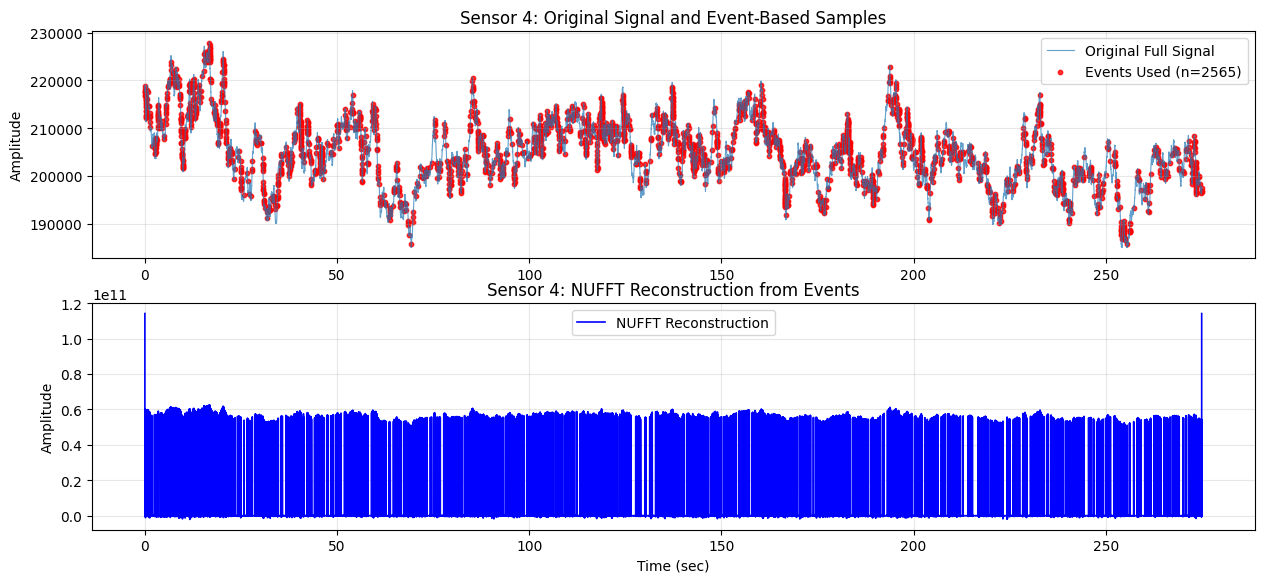

In [95]:
def nufft_from_events(df, sensor_name, N=None, threshold_factor=3, plot=True):
    # Extract full time and signal
    t_full = df['Time (sec)'].values
    x_full = df[sensor_name].values
    
    # Detect events (rate of change based)
    sensor_values = df[sensor_name].values
    time_values = df['Time (sec)'].values
    
    rate_of_change = np.abs(np.diff(sensor_values) / np.diff(time_values))
    roc_mean = np.mean(rate_of_change)
    roc_std = np.std(rate_of_change)
    roc_threshold = roc_mean + threshold_factor * roc_std
    
    # Find indices where rate of change exceeds threshold
    event_indices = np.where(rate_of_change > roc_threshold)[0] + 1
    
    # Add first and last points to avoid boundary issues
    event_indices = np.unique(np.concatenate([[0], event_indices, [len(t_full)-1]]))
    
    # Select event-based samples
    t_events = t_full[event_indices]
    x_events = x_full[event_indices]
    
    print(f"Using {len(t_events)} event samples out of {len(t_full)} total samples")
    
    # Set up frequency grid
    if N is None:
        N = len(t_full)  
    
    # Time normalization: map to [-π, π] (more standard for NUFFT)
    t_min, t_max = t_full[0], t_full[-1]
    duration = t_max - t_min
    
    # Normalize event times to [-π, π]
    t_norm_events = 2 * np.pi * (t_events - t_min) / duration - np.pi
    
    # Normalize full time grid to [-π, π] 
    t_norm_full = 2 * np.pi * (t_full - t_min) / duration - np.pi
    
    try:
        # NUFFT Type 1: nonuniform time samples → uniform frequency coefficients
        # This gives us Fourier coefficients X_k for k = -N/2, ..., N/2-1
        X_k = finufft.nufft1d1(t_norm_events, x_events.astype(complex), N)
        
        # NUFFT Type 2: uniform frequency coefficients → nonuniform time samples
        # Reconstruct at the original time points
        x_recon = finufft.nufft1d2(t_norm_full, X_k)
        
        # Make sure reconstruction is real if input was real
        if np.all(np.isreal(x_events)):
            x_recon = x_recon.real
            
    except Exception as e:
        print(f"NUFFT failed: {e}")
        return None
    
    if plot:
        # Plot original signal and event points
        plt.figure(figsize=(15, 10))
        
        # Subplot 1: Original signal with events
        plt.subplot(3, 1, 1)
        plt.plot(t_full, x_full, label='Original Full Signal', alpha=0.7, linewidth=0.8)
        plt.scatter(t_events, x_events, color='red', s=10, alpha=0.8, label=f'Events Used (n={len(t_events)})')
        plt.title(f'{sensor_name}: Original Signal and Event-Based Samples')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Reconstructed signal
        plt.subplot(3, 1, 2)
        plt.plot(t_full, x_recon, label='NUFFT Reconstruction', linewidth=1.2, color='blue')
        plt.title(f'{sensor_name}: NUFFT Reconstruction from Events')
        plt.xlabel('Time (sec)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    return {
        't_events': t_events,
        'x_events': x_events,
        'x_recon': x_recon,
        'X_k': X_k,
        'mse': np.mean((x_full - x_recon)**2),
        'mae': np.mean(np.abs(x_full - x_recon)),
        'compression_ratio': len(t_full) / len(t_events)
    }

# Example usage:
result = nufft_from_events(enose1_data, sensor_name='Sensor 4')


## Literature Review Takeaways

- A heavy-tailed spectrum means signal power decays slowly across frequencies, often following a power law (e.g., $1/f^\alpha$)

- This implies no sharp frequency cutoff — the signal is not bandlimited

- Many systems with such spectral behavior indicate self-similarity: the signal exhibits similar patterns across multiple time scales or resolutions

- In olfaction, this reflects the complex, turbulent structure of odor plumes at many scales

Is neuromorphic sampling optimal for self-similar signals, and can we recover them accurately?

## Future Directions
- Benchmark NUFFT vs. FFT on neuromorphic olfaction data
    - Compare the fidelity, robustness, and utility of NUFFT and FFT for analyzing real or synthetic event-based olfactory signals

- Can neuromorphic sampling efficiently capture heavy-tailed signals? 
    - Explore whether change-driven sampling strategies are better suited for non-bandlimited data

- What is the true spectral structure of olfactory signals? 
    - Investigate whether olfaction exhibits dominant frequencies or structure that NUFFT can exploit, even without strict bandlimiting

- How can we adapt NUFFT to input-dependent (signal-driven) sampling? 
    - Traditional NU sampling assumes static sample points; neuromorphic spike times are inherently nonlinear and signal-dependent

- End target: publish by end of year 

## Summary
- Neuromorphic signals are nonuniformly sampled, challenging FFT assumptions and limiting its use for accurate reconstruction

- While FFT may suffice for basic spectral inspection, NUFFT better preserves structure and fidelity when reconstruction matters

- NUFFT provides a computationally efficient tool for Fourier analysis and reconstruction of nonuniformly sampled data

- Explored NUFFT for a simple sine wave, toy spike-based neuromorphic signal, and real neuromorphic olfaction data, highlighting both strengths and challenges

These findings open a variety of research directions!



# Thank You